In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from astropy.stats import funcs
from matplotlib.colors import LogNorm
from astropy.table import Table
from astropy.timeseries import LombScargle, BoxLeastSquares
from scipy.optimize import curve_fit

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
def _gaus(x, a, b, x0, sigma):
    """
    a : the amplitude
    b : the constant offset
    x0 : the center of the Gaussian
    sigma : the width of the Gaussian
    """
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b

5700
143.9799999999882


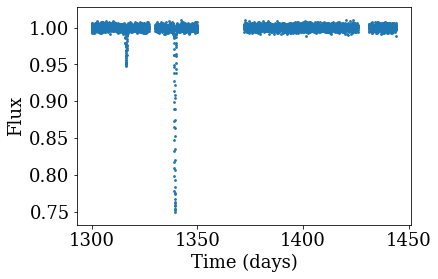

In [4]:
# make a fake LC to think about

time = np.hstack((np.arange(1300,1327, 0.02), 
                  np.arange(1330,1350, 0.02), 
                  np.arange(1372,1426, 0.02), 
                  np.arange(1431,1444, 0.02)))

E1_TIME = 1339.23984
E2_TIME = 1316.2345

flux = (np.ones_like(time) + 
        _gaus(time, -0.05, 0., E2_TIME, 0.2) + 
        _gaus(time, -0.25, 0., E1_TIME, 0.22) + 
        np.random.normal(loc=0, scale=0.003, size=len(time)))

plt.scatter(time, flux, s=3)
plt.xlabel("Time (days)")
plt.ylabel('Flux')
print(len(time))
print(max(time) - min(time))

(1338.23984, 1340.23984)

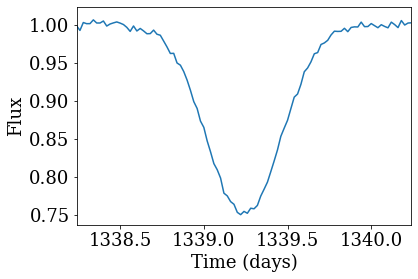

In [5]:
plt.plot(time, flux)
plt.xlabel("Time (days)")
plt.ylabel('Flux')

plt.xlim(E1_TIME - 1, E1_TIME + 1)

What are the Periods and Eccentricities that are constrained, given these data?

Let's adopt a couple simple definitions:

- P = Period of time between PRIMARY eclipses (in days)
- E = the separation in phase between primary eclipses of the SECONDARY eclipse (from -1 to 1)

In [6]:
# not sure how to get to the plot I envision, start just making things and we'll see how it goes!
# thought: maybe do in windows of "sigma" (eclipse duration) to save memory... 

# Periods to search over:
# minP = time between Primary & Secondary Eclipse in this case
# maxP = total timespan of data + minP
minP = np.abs(E1_TIME - E2_TIME)
maxP = (np.max(time) - np.min(time)) + minP

Window = 0.5 # days (approx the total eclipse width)

P = np.arange(minP, maxP+Window, Window)

# E's to search over:
# from -1 to 1
# in steps of Window / maxP ?
E = np.arange(0, 1 + Window/maxP, Window/maxP)

print(P.size, E.size)

PP, EE = np.meshgrid(P, E, indexing='ij')

289 335


Text(0.5, 1.0, 'Period Coverage')

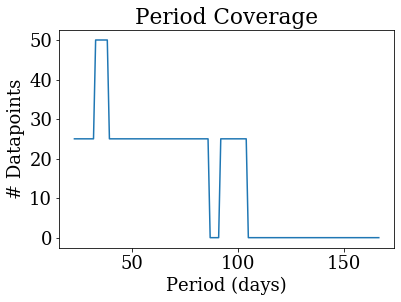

In [7]:
# from the reference point of the primary eclipse time, I guess do a loop and 
# brute force look for any coverage within P,E windows?
# there MUST be a more elegant way to do this w/ a histogram in a single loop...

# let's start w/ just Periods (1-D)
coverage_P, bP = np.histogram(np.abs(time - E1_TIME), bins=P)

plt.plot(P[:-1], coverage_P)
plt.xlabel('Period (days)')
plt.ylabel('# Datapoints')
plt.title('Period Coverage')

# I read this as: regions w/ 0 data = possible periods

Text(0.5, 1.0, 'Coverage with P=50')

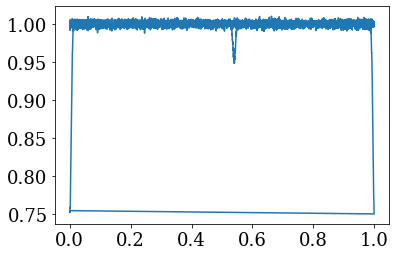

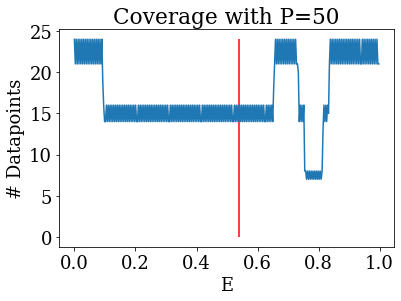

In [8]:
# now let's try 1 period, explore possible E
P_i = 50 # d
plt.figure()
plt.plot(((time - E1_TIME)/P_i) % 1, flux)

coverage_E, bE = np.histogram(((time - E1_TIME)/P_i) % 1, bins=E)

plt.figure()

plt.plot(E[:-1], coverage_E)
plt.vlines(((E2_TIME - E1_TIME)/P_i) % 1, 0,max(coverage_E), color='r')
plt.xlabel('E')
plt.ylabel('# Datapoints')
plt.title('Coverage with P='+str(P_i))

In [9]:
# coverage = np.zeros_like(EE)

# for i in range(len(P)):
#         coverage[i,:-1], _ = np.histogram(((time - E1_TIME)/P[i]) % 1, bins=E)

In [10]:
# plt.figure(figsize=(10,6))
# plt.pcolormesh(PP,EE, coverage, cmap=plt.cm.magma_r)
# plt.xlabel('Period (days)')
# plt.ylabel('E')
# plt.title('Secondary Eclipse Coverage')
# cb = plt.colorbar()
# cb.set_label('# Datapoints')

In [11]:
# no no no, i'm doing this wrong.... trying to code on the fly while parenting is not good for new ideas, LOL

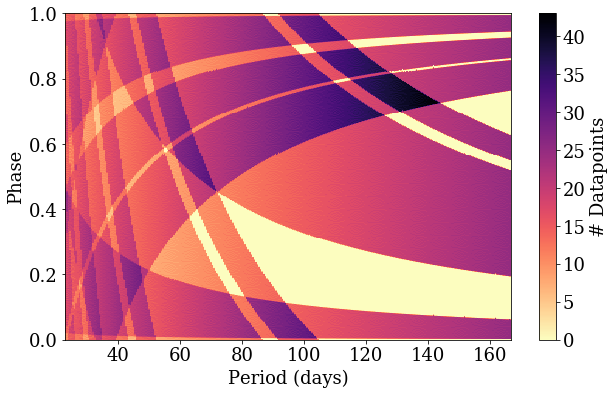

In [12]:
# OK, this is actually just the Phase-coverage of data as a function of Period...
coverage = np.zeros_like(EE)
pc = np.zeros_like(P)
for i in range(len(P)):
        oki = np.where(((time < (E2_TIME - Window)) | 
                        (time > (E2_TIME + Window))) & 
                       ((time < (E1_TIME - Window)) | 
                        (time > (E1_TIME + Window))))[0]
        coverage[i,:-1], _ = np.histogram(((time[oki] - E1_TIME) % P[i]) / P[i], bins=E)
        pc[i] = ((E2_TIME - E1_TIME) % P[i]) / P[i]
        
plt.figure(figsize=(10,6))
plt.pcolormesh(PP,EE, coverage, cmap=plt.cm.magma_r)

# plt.plot(P,pc, c='C0', lw=4, label='Secondary Eclipse Phase')
# plt.legend(fontsize=12)
plt.xlabel('Period (days)')
plt.ylabel('Phase')

cb = plt.colorbar()
cb.set_label('# Datapoints')
plt.savefig('Phase_coverage.png', bbox_inches='tight', pad_inches=0.25, dpi=200)

In [13]:
# Given 1 primary and 1 secondary eclipse, assuming a steady period
# -> P & E are directly tied together as a function of P based on our observations
# -> we can rule out periods if there is data within EITHER the primary or secondary eclipse window!

is1 = np.zeros_like(P)
is2 = np.zeros_like(P)

for i in range(len(P)):
    win_i = Window / P[i] # the eclipse window size in phase to examine at this period 
    
    # the data to examine that is outside the two eclipses (maybe not needed...? how to generalize?)
    oki = np.where(((time < (E2_TIME - Window)) | 
                    (time > (E2_TIME + Window))) & 
                   ((time < (E1_TIME - Window)) | 
                    (time > (E1_TIME + Window))))[0]
    
    pc_i = ((E2_TIME - E1_TIME) % P[i]) / P[i]

    phase_i = ((time[oki] - E1_TIME) % P[i]) / P[i]

    is1[i] = sum((phase_i <= win_i) | (phase_i >= (1-win_i)))
    is2[i] = sum((phase_i >= (pc_i - win_i)) & (phase_i <= (pc_i + win_i)))

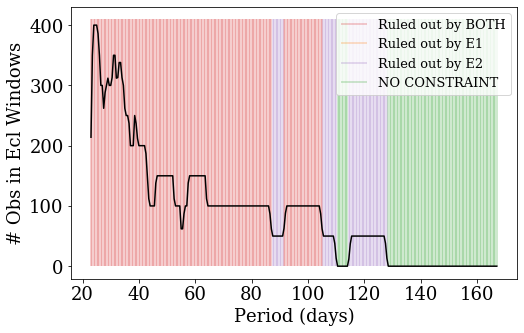

In [14]:
plt.figure(figsize=(8,5))
plt.plot(P, is1+is2, c='k')
plt.vlines(P[(is1 > 0) & (is2 > 0)], 0,410, color='C3', alpha=0.3, label='Ruled out by BOTH')
plt.vlines(P[(is1 > 0) & (is2 == 0)], 0,410, color='C1', alpha=0.3, label='Ruled out by E1')
plt.vlines(P[(is1 == 0) & (is2 > 0)], 0,410, color='C4', alpha=0.3, label='Ruled out by E2')
plt.vlines(P[(is1 == 0) & (is2 == 0)], 0,410, color='C2', alpha=0.3, label='NO CONSTRAINT')
plt.legend(fontsize=13)

plt.xlabel('Period (days)')
plt.ylabel('# Obs in Ecl Windows')

plt.savefig('P_allowed.png', bbox_inches='tight', pad_inches=0.25, dpi=200)

In [17]:
from thegrid import phase_coverage

In [21]:
P, is1, is2, PP, EE, coverage = phase_coverage(time, E1_TIME, E2_TIME, minP=10., maxP=150, return_coverage=True)

Text(0, 0.5, 'Phase')

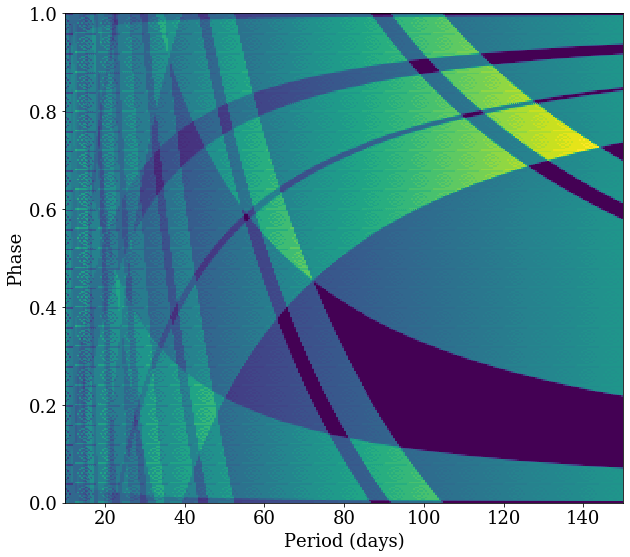

In [24]:
plt.figure(figsize=(10,9))
plt.pcolormesh(PP,EE, coverage)
plt.xlabel('Period (days)')
plt.ylabel('Phase')

In [25]:
P.shape

(281,)